In [31]:
import os
import sys
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
dir_path = 'data/2020-02/'

In [5]:
# Get csv paths
paths = os.listdir(dir_path)

# Get dfs for each day
dfs_feb = [pd.read_csv(dir_path+f, engine='python') for f in paths]

# Get mean bw per day
means = [df.mean(axis=1) for df in dfs_feb]


In [13]:
# Construct dataframe with relays and their daily means
df_temp = pd.DataFrame()
df_temp['fingerprint'] = dfs_feb[0]['fingerprint']
for i,m in enumerate(means):
    df_temp['day '+str(i+1)] = m
    
# Find monthly bandwidth mean of each relay
df = pd.DataFrame()
df['fingerprint'] = df_temp['fingerprint']
df['mean_bw'] = df_temp.mean(axis=1)
df = df.sort_values(by='mean_bw', ascending=False).reset_index()
df

,index,fingerprint,mean_bw
0,4622,niftyporcupine 7E281CD2C315C4F7A84BC7C8721C3BC...,51115.981096
1,693,F3Netze 7327876AE79C997DFE311A7B15B4FA875736BBD1,50484.524732
2,4625,niftyrabbitrat 25526E61B8BC22B662E3D4A50504021...,49166.550882
3,694,F3Netze 8E38B11E849336D62AB6264FBAE9B03C70F07863,49006.530403
4,4624,niftyquokka 906DCB390F2BA987AE258D745E60BAAABA...,48928.786704
...,...,...,...
5927,98,ADEL ABF554C44C97825F46B1C9DEE14A2E2B62025D7E,986.798992
5928,190,AnonKorea00 50402D3DAD83E8923CD7715917284C8489...,980.391698
5929,1,0000001dxx B9609624E26C705289E57F95E30FD88D159...,674.035050
5930,2286,Unnamed 3864A437EDAEBF7859B9CC71348E1214BEE5BF62,419.399023


In [5]:
# Save the average February data in a csv
#df.to_csv('csvs/feb_avg_bws.csv', index=False)

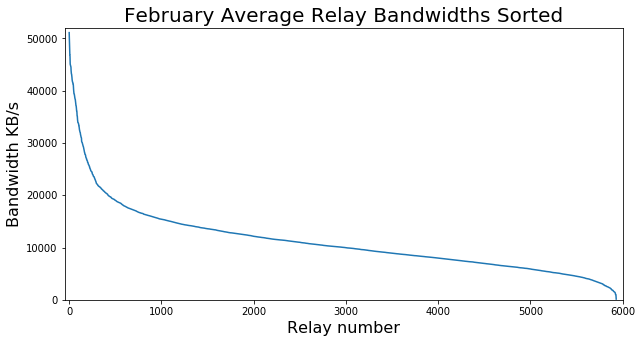

In [48]:
# See all sorted bandwidths
plt.figure(figsize=(10,5))
plt.plot(range(df.shape[0]), df['mean_bw'])
plt.title('February Average Relay Bandwidths Sorted', size=20)
plt.axis([-50, 6000, 0, 52000])
plt.ylabel('Bandwidth KB/s', size=16)
plt.xlabel('Relay number', size=16)
plt.show()

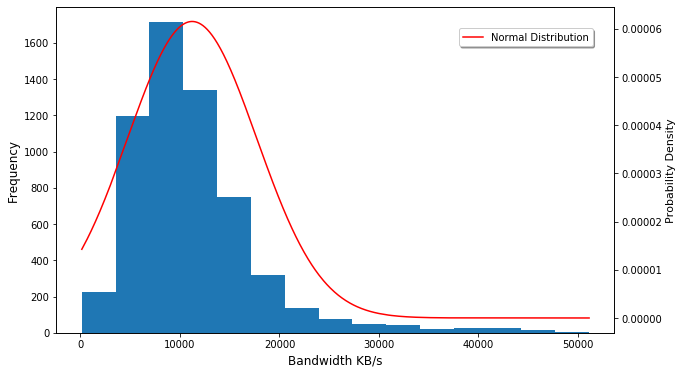

In [83]:
# Histogram
bw = df['mean_bw']
norm_distr = stats.norm.pdf(bw, np.mean(bw), np.std(bw))

fig, axs = plt.subplots(figsize=(10,6))
axs.hist(bw, density=False, bins=15)
axs0 = axs.twinx()
axs0.plot(bw, norm_distr, color='red', label='Normal Distribution')

#axs.set_title('February 2020 mean Tor bandwidth weights distribution', size=16, pad=15)
axs.set_xlabel('Bandwidth KB/s', size=12)
axs.set_ylabel('Frequency', size=12)
axs0.set_ylabel('Probability Density', size=11)

fig.legend(loc='center', bbox_to_anchor=(0.73,0.78), shadow=True)
plt.savefig('figures/Bandwidth_Distribution_Tor.png')

In [72]:
# See cumulative weight distribution and drop any relays outside 95% of variance
cum_weights = [(df['mean_bw'][:i].sum())/df['mean_bw'].sum() for i in range(1,df.shape[0]+1)]
relay_cutoff = 0
for i in range(df.shape[0]):
    if cum_weights[i]> 0.95:
        relay_cutoff = i
        break

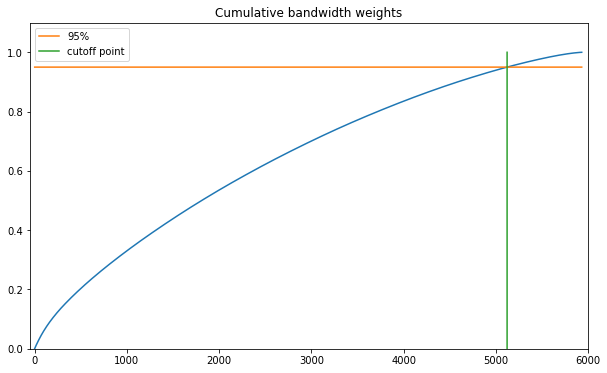

In [73]:
x = df.shape[0]
plt.figure(figsize=(10,6))
plt.plot(range(x), cum_weights)
plt.plot(range(x), [0.95] * x, label='95%')    # 95%
plt.plot([relay_cutoff]*x, cum_weights, label='cutoff point')

# plt.plot(range(x), [0.10] * x, label='10%')    # 95%
# plt.plot(range(x), [0.20] * x, label='20%')    # 95%
# plt.plot(range(x), [0.30] * x, label='30%')    # 95%
# plt.plot(range(x), [0.40] * x, label='40%')    # 95%
# plt.plot(range(x), [0.50] * x, label='50%')    # 95%
# plt.plot(range(x), [0.60] * x, label='60%')    # 95%
# plt.plot(range(x), [0.70] * x, label='70%')    # 95%
# plt.plot(range(x), [0.80] * x, label='80%')    # 95%
# plt.plot(range(x), [0.90] * x, label='90%')    # 95%

plt.axis([-50, 6000, 0, 1.1])
plt.legend()
plt.title('Cumulative bandwidth weights')
plt.show()

In [9]:
# Remove the top 5% of relays
i = 0
while(1):
    if cum_weights[i]>0.95:
        break
    i+=1
cum_weights_95 = cum_weights[:i]

In [10]:
# Get ordered, non-null, cumulative list
Rc = cum_weights_95
#Rc = [0.2, 0.35, 0.5, 0.65, 0.75, 0.85, 0.9, 0.95, 1]

# Get N
N = 20

# Calculate index gap
gap = cum_weights[-1] / (N+1)

# Initialize while loop variables
i = 0
samples = []
samples_w = []
current_limit = gap

# Loop through the cumulative weights finding the N samples
while (i < len(Rc)) and (len(samples) < N):
    if Rc[i] >= current_limit:
        samples.append(i)
        samples_w.append(Rc[i])
        current_limit += gap
    i += 1

# Return sample indexes
print(0,'...',len(Rc))
samples


0 ... 5122


[75,
 175,
 303,
 456,
 626,
 813,
 1013,
 1225,
 1450,
 1687,
 1937,
 2202,
 2481,
 2777,
 3092,
 3428,
 3792,
 4188,
 4632]

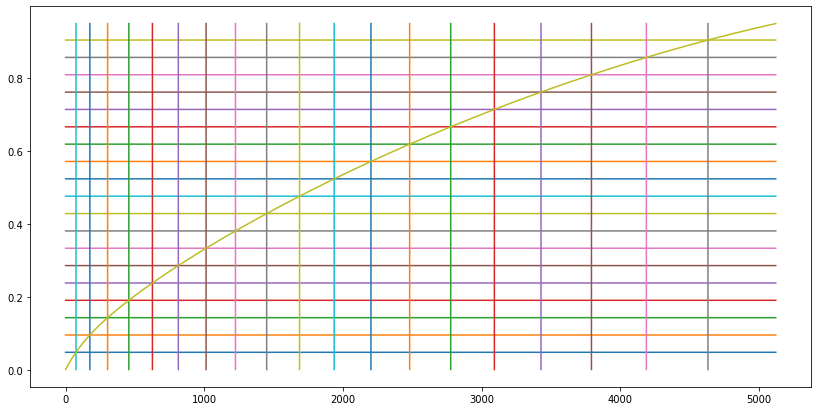

In [11]:
s = len(samples_w)
x = len(Rc)

plt.figure(figsize=(14,7))

# Plot cumulative lines
for n in range(s):
    plt.plot(range(x), [samples_w[n]]*x)
    
# Plot cumulative lines
for n in range(s):
    plt.plot([samples[n]]*x, Rc)

plt.plot(range(x), Rc)



In [12]:
# NOTE
'''
Make method that returns the cumulative weights
Make method that finds the sample indexes based on the cumulative weights
'''

'\nMake method that returns the cumulative weights\nMake method that finds the sample indexes based on the cumulative weights\n'

In [19]:
final_samples = [0] + samples
df.loc[final_samples].drop('index', axis=1)

,fingerprint,mean_bw
0,niftyporcupine 7E281CD2C315C4F7A84BC7C8721C3BC...,51115.981096
75,niftysnowshoehare A3901DDB7799A11E9BAB90BD1DDA...,37085.256459
175,Piratenpartei1 D1C5F5F8FAFA2F98A84753416BF83B8...,27785.412571
303,Cryptocat 35DA04A92634AF2392CBA6AF158E00B5589A...,22097.896739
456,nels94 8EF052033309D854D6206A4C30F17AD27C87893E,19565.348693
626,crmh 7A6391CBDE6AFF119B18A1BF0EE7E92D9A41BB4E,17701.338847
813,Seccom03 22A6BE98D201B101C32661739967BF4DED12EF96,16364.006616
1013,Quintex46 C78AFFEEE320EA0F860961763E613FD2FAC8...,15384.098141
1225,pcfreak 0E452A30E7E05744071678E0A059BDDB468930CD,14452.513941
1450,nonanet02 414385E0BA88B6F7870C389A60819BB06308...,13747.641777


In [20]:
# Write selected relays to csv
df.loc[final_samples].drop('index', axis=1).to_csv('csvs/20_relays.csv', index=False)